# GLM: Mini-batch ADVI on hierarchical regression model

[**Original Tutorial**](https://docs.pymc.io/notebooks/GLM-hierarchical-advi-minibatch.html)

Regression models have independent variables ($x$).
They affect the likelihood function, but are not random variables.
"When using mini-batch, we should take care of that."

In [19]:
%env THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore

import re
import sys
from typing import Iterable, List, Optional, Tuple

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import theano
import theano.tensor as tt

%config InlineBackend.figure_format = 'retina'
gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))

%load_ext memory_profiler

RANDOM_SEED = 606
np.random.seed(RANDOM_SEED)

env: THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [2]:
data = pd.read_csv(pm.get_data("radon.csv"))

county_names = data.county.unique()
county_idx = data["county_code"].values
n_counties = len(county_names)
total_size = data.shape[0]

For this example, `log_radon_t` is the dependent variable ($y$) and `floor_t` and `county_idx_t` are the independent variables ($x$).

In [3]:
theano.config.profile = True
theano.config.profile_memory = True

In [4]:
batch_size = 100
log_radon_t = pm.Minibatch(data.log_radon.values, batch_size)
floor_t = pm.Minibatch(data.floor.values, batch_size)
county_idx_t = pm.Minibatch(data.county_code.values, batch_size)

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [5]:
with pm.Model() as hierarchical_model_batch:
    # Hyperpriors
    μ_α = pm.Normal("μ_α", 0, 100 ** 2)
    σ_α = pm.Uniform("σ_α", lower=0, upper=100)
    μ_β = pm.Normal("μ_β", 0, 100 ** 2)
    σ_β = pm.Uniform("σ_β", 0, 100)

    # Prios
    α = pm.Normal("α", μ_α, σ_α, shape=n_counties)
    β = pm.Normal("β", μ_β, σ_β, shape=n_counties)

    # Main level
    radon_est = α[county_idx_t] + β[county_idx_t] * floor_t

    # Likelihood
    ϵ = pm.Uniform("ϵ", lower=0, upper=100)
    radon_like = pm.Normal(
        "radon_like", radon_est, ϵ, observed=log_radon_t, total_size=total_size
    )

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.


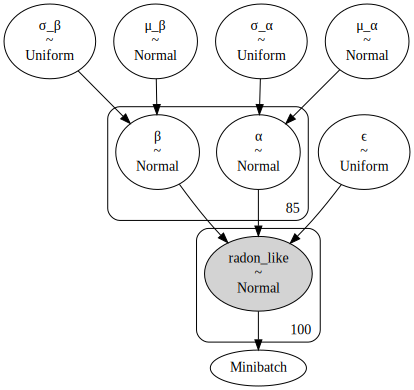

In [6]:
pm.model_to_graphviz(hierarchical_model_batch)

Run ADVI with mini-batch.

In [23]:
%%time
with hierarchical_model_batch:
    approx = pm.fit(
        100000,
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)],
        random_seed=RANDOM_SEED,
    )

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.


Finished [100%]: Average Loss = 130.27


CPU times: user 11min 51s, sys: 18.7 s, total: 12min 9s
Wall time: 14min 11s


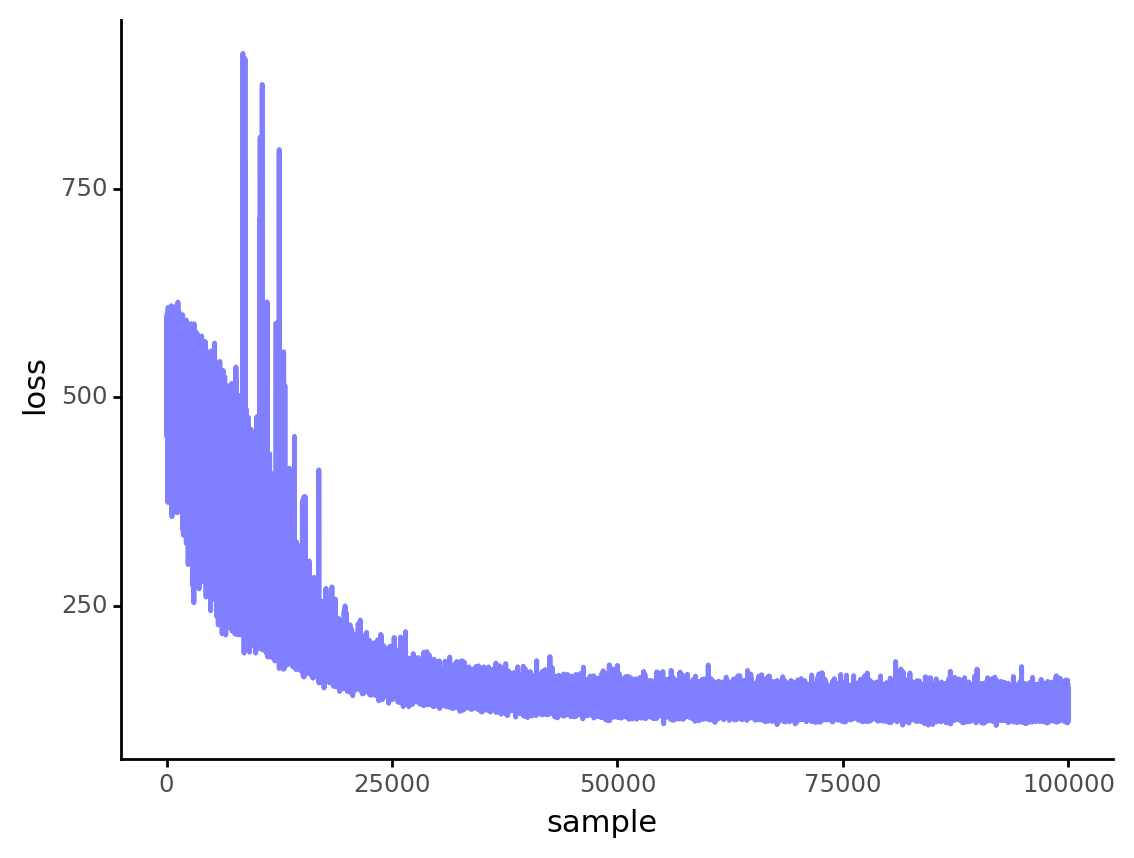

<ggplot: (353796340)>

In [24]:
plot_data = pd.DataFrame({"x": np.arange(0, len(approx.hist)), "loss": approx.hist})

(
    gg.ggplot(plot_data, gg.aes(x="x", y="loss"))
    + gg.geom_line(alpha=0.5, color="blue", size=1)
    + gg.labs(x="sample", y="loss")
)

In [25]:
hierarchical_model_batch.profile(hierarchical_model_batch.logpt).summary()

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
Function profiling
  Message: /usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/model.py:1253
  Time in 1000 calls to Function.__call__: 1.061092e+00s
  Time in Function.fn.__call__: 0.9833240509033203s (92.671%)
  Time in thunks: 0.1417069435119629s (13.355%)
  Total compile time: 1.116527e+00s
    Number of Apply nodes: 58
    Theano Optimizer time: 4.777908e-01s
       Theano validate time: 6.259918e-03s
    Theano Linker time (includes C, CUDA code generation/compiling): 0.07734513282775879s
       Import time 1.759672e-02s
       Node make_thunk time 7.457900e-02s
           Node Elemwise{Composite{(i0 * scalar_sigmoid(i1))}}(TensorConstant{100.0}, ϵ_interval__) time 2.213693e-02s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((GE(i1, i2) * LE(i1, i3))), i4, 

---

## Profiling use of Minibatch with ADVI and MCMC

### Data

I will run ADVI and MCMC sampling with and without minibatch.
For MCMC, I will also compare the results of ordering or shuffling the data.

In [10]:
data.head()

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


In [11]:
data = data.sort_values(["county_code", "floor", "log_radon"]).reset_index(drop=True)

# Single numpy array for data (non-batched)
log_radon = data.log_radon.values
floor = data.floor.values
county_idx = data.county_code.values

# Batched data
batch_size = 100
log_radon_batch = pm.Minibatch(log_radon, batch_size)
floor_batch = pm.Minibatch(floor, batch_size)
county_idx_batch = pm.Minibatch(county_idx, batch_size)

n_counties = len(np.unique(county_idx))
total_size = data.shape[0]

#### Shuffled
data = data.copy().sample(frac=1).reset_index(drop=True)

# Single numpy array for data (non-batched)
log_radon_S = data.log_radon.values
floor_S = data.floor.values
county_idx_S = data.county_code.values

# Batched data
batch_size = 100
log_radon_batch_S = pm.Minibatch(log_radon_S, batch_size)
floor_batch_S = pm.Minibatch(floor_S, batch_size)
county_idx_batch_S = pm.Minibatch(county_idx_S, batch_size)

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Model

I will use the same model as before, and create a function to build it and sample using either ADVI or MCMC.

In [12]:
def build_and_fit_hierarchical_model(
    radon_data: Iterable[float],
    floor_data: Iterable[float],
    county_idx: Iterable[int],
    n_counties: int,
    total_data_size: int,
    sampling_method: str,
) -> Tuple[pm.model.Model, pm.backends.base.MultiTrace]:

    with pm.Model() as model:
        # Hyperpriors
        μ_α = pm.Normal("μ_α", 1, 5)
        σ_α = pm.HalfNormal("σ_α", 2)
        μ_β = pm.Normal("μ_β", -1, 2)
        σ_β = pm.HalfNormal("σ_β", 1)

        # Prios
        α = pm.Normal("α", μ_α, σ_α, shape=n_counties)
        β = pm.Normal("β", μ_β, σ_β, shape=n_counties)

        # Main level
        radon_est = α[county_idx] + β[county_idx] * floor_data

        # Likelihood
        ϵ = pm.HalfNormal("ϵ", 5)
        radon_liklihood = pm.Normal(
            "radon_liklihood",
            radon_est,
            ϵ,
            observed=radon_data,
            total_size=total_data_size,
        )

    draws = 1000

    if sampling_method == "advi":
        with model:
            approx = pm.fit(
                100000,
                method="advi",
                callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=0.01)],
                random_seed=RANDOM_SEED,
            )
            trace = approx.sample(draws=draws)
    elif sampling_method == "mcmc":
        with model:
            trace = pm.sample(
                draws=draws,
                tune=draws,
                chains=2,
                cores=2,
                random_seed=RANDOM_SEED,
                return_inferencedata=False,
            )

    return model, trace

In [13]:
### ADVI
advi_singlebatch = build_and_fit_hierarchical_model(
    radon_data=log_radon,
    floor_data=floor,
    county_idx=county_idx,
    n_counties=n_counties,
    total_data_size=total_size,
    sampling_method="advi",
)

advi_minibatch = build_and_fit_hierarchical_model(
    radon_data=log_radon_batch,
    floor_data=floor_batch,
    county_idx=county_idx_batch,
    n_counties=n_counties,
    total_data_size=total_size,
    sampling_method="advi",
)

### MCMC (sorted data)
mcmc_singlebatch = build_and_fit_hierarchical_model(
    radon_data=log_radon,
    floor_data=floor,
    county_idx=county_idx,
    n_counties=n_counties,
    total_data_size=total_size,
    sampling_method="mcmc",
)

mcmc_minibatch = build_and_fit_hierarchical_model(
    radon_data=log_radon_batch,
    floor_data=floor_batch,
    county_idx=county_idx_batch,
    n_counties=n_counties,
    total_data_size=total_size,
    sampling_method="mcmc",
)

### MCMC (shuffled data)
mcmc_singlebatch_S = build_and_fit_hierarchical_model(
    radon_data=log_radon_S,
    floor_data=floor_S,
    county_idx=county_idx_S,
    n_counties=n_counties,
    total_data_size=total_size,
    sampling_method="mcmc",
)

mcmc_minibatch_S = build_and_fit_hierarchical_model(
    radon_data=log_radon_batch_S,
    floor_data=floor_batch_S,
    county_idx=county_idx_batch_S,
    n_counties=n_counties,
    total_data_size=total_size,
    sampling_method="mcmc",
)

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.


Finished [100%]: Average Loss = 1,071.2
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.


Finished [100%]: Average Loss = 116.98
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
Multiprocess samplin

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6715732309871704, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/s

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 83 seconds.
There were 981 divergences after tuning. Increase `target_accept` or reparameterize.
There were 978 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α, σ_β, μ_β, σ_α, μ_α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 226 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.50668788285416, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α, σ_β, μ_β, σ_α, μ_α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 82 seconds.
There were 967 divergences after tuning. Increase `target_accept` or reparameterize.
There were 973 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [14]:
labels = [
    "ADVI (singlebatch)",
    "ADVI (minibatch)",
    "MCMC (singlebatch)",
    "MCMC (minibatch)",
]
models = [
    x[0] for x in [advi_singlebatch, advi_minibatch, mcmc_singlebatch, mcmc_minibatch]
]

for model, label in zip(models, labels):
    title = "=" * 10 + " " + label + " " + "=" * 10
    border = "=" * len(title)
    print(border)
    print(title)
    print(border)
    print(model.profile(model.logpt).summary_memory(sys.stdout))

========== ADVI (singlebatch) ==========


/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.


Memory Profile
(Sparse variables are ignored)
(For values in brackets, it's for linker = c|py
---
    Max peak memory with current setting
        CPU: 7KB (7KB)
        GPU: 0KB (0KB)
        CPU + GPU: 7KB (7KB)
    Max peak memory with current setting and Theano flag optimizer_excluding=inplace
        CPU: 11KB (11KB)
        GPU: 0KB (0KB)
        CPU + GPU: 11KB (11KB)
    Max peak memory if allow_gc=False (linker don't make a difference)
        CPU: 8KB
        GPU: 0KB
        CPU + GPU: 8KB
---

    <Sum apply outputs (bytes)> <Apply outputs shape> <created/inplace/view> <Apply node>

     {node_outputs_size:9d}B  [(919,)] c AdvancedSubtensor1(β, TensorConstant{[ 0  0  0 .. 83 84 84]})
     {node_outputs_size:9d}B  [(919,)] c AdvancedSubtensor1(α, TensorConstant{[ 0  0  0 .. 83 84 84]})
     {node_outputs_size:9d}B  [(919,)] i Elemwise{Composite{Switch(i0, (i1 * ((i2 * i3 * sqr((i4 - Cast{float32}((i5 + (i6 * i7)))))) + i8)), i9)}}[(0, 5)](Elemwise{Composite{Cast{int8}(GT(i0,

In [15]:
def summarize_results(
    res: Tuple[pm.model.Model, pm.backends.base.MultiTrace],
    name: str,
    var_names: Optional[List[str]] = None,
    filter_vars: Optional[str] = None,
) -> pd.DataFrame:
    df = az.summary(
        az.from_pymc3(trace=res[1], model=res[0]),
        var_names=var_names,
        hdi_prob=0.89,
        filter_vars=filter_vars,
    )
    df["model"] = name
    return df


labels = ["ADVI (singlebatch)", "ADVI (minibatch)", "MCMC (singlebatch)"]
res = [advi_singlebatch, advi_minibatch, mcmc_singlebatch]

hyperpriors_summaries = pd.concat(
    [
        summarize_results(r, l, var_names=["μ|σ"], filter_vars="regex")
        for r, l in zip(res, labels)
    ]
)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.


In [16]:
def plot_comparison_of_estimate_summaries(
    df: pd.DataFrame, x="index", xlab: str = "variable", point_size: float = 1.0
) -> gg.ggplot:
    pos = gg.position_dodge(width=0.7)

    return (
        gg.ggplot(df, gg.aes(x=x, color="model"))
        + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
        + gg.geom_linerange(
            gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), alpha=0.5, position=pos
        )
        + gg.geom_point(gg.aes(y="mean"), position=pos, size=point_size)
        + gg.labs(x=xlab, y="posterior")
    )

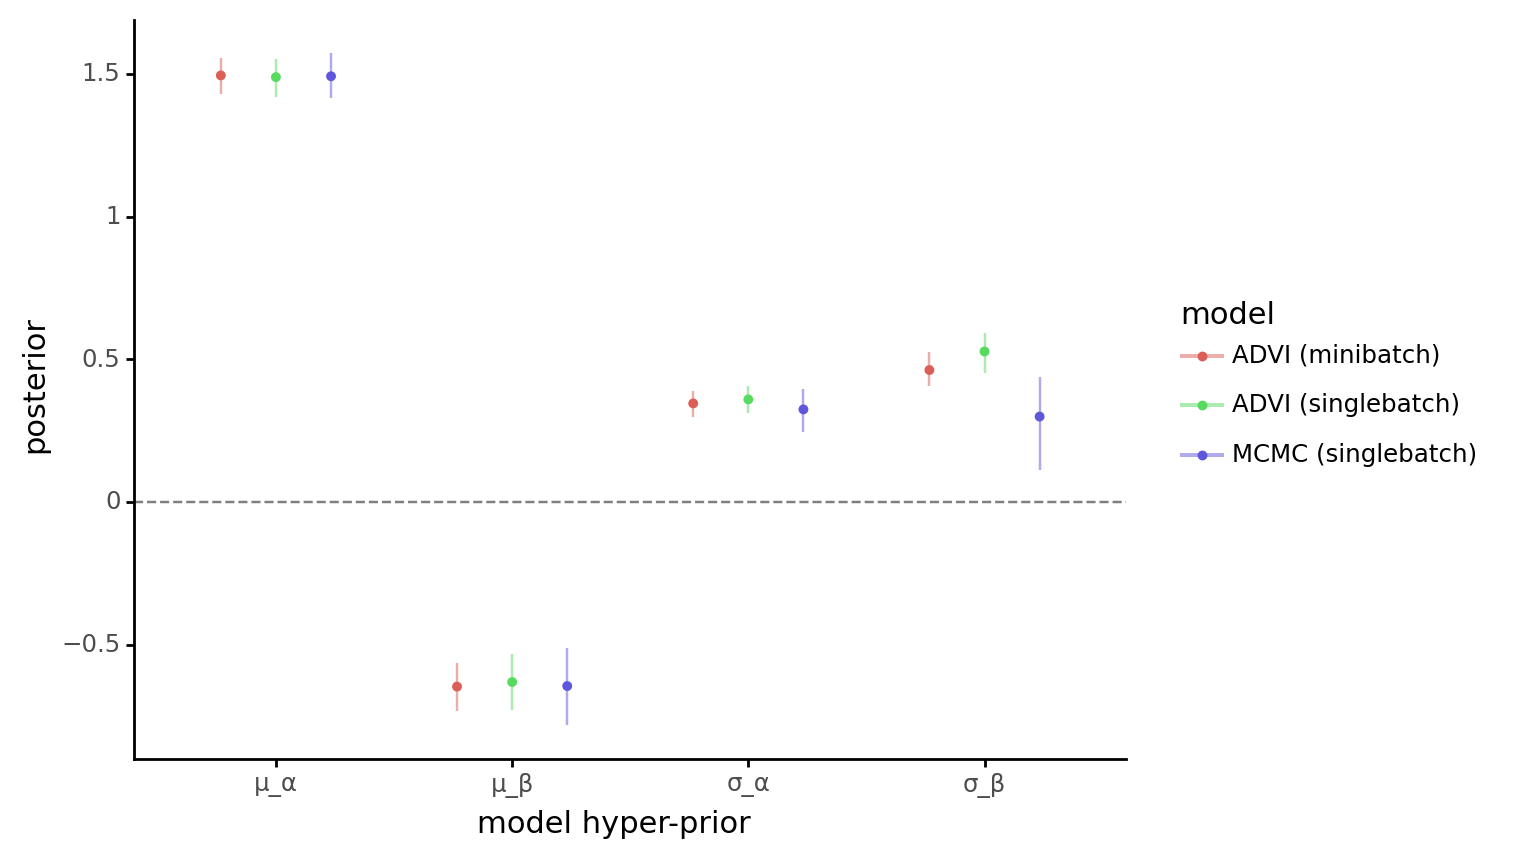

<ggplot: (348779361)>

In [17]:
plot_comparison_of_estimate_summaries(
    hyperpriors_summaries.reset_index(drop=False), xlab="model hyper-prior"
)

In [20]:
mainvars_summaries = pd.concat(
    [
        summarize_results(r, l, var_names=["^α|^β"], filter_vars="regex")
        for r, l in zip(res, labels)
    ]
)

# Is α or β
mainvars_summaries["var_group"] = [
    "α" if re.search("α", x) else "β" for x in mainvars_summaries.index.values
]

# County index
mainvars_summaries["var_idx"] = [
    int("".join(re.findall(r"\d", x))) for x in mainvars_summaries.index.values
]

mainvars_summaries.head()

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/link/vm.py:909: UserWarning: CVM does not support memory profile, using Stack VM.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,model,var_group,var_idx
α[0],1.175,0.284,0.710,1.603,0.009,0.006,1004.0,1001.0,1003.0,937.0,NaN,ADVI (singlebatch),α,0
α[1],0.984,0.103,0.822,1.151,0.003,0.002,1086.0,1060.0,1083.0,854.0,NaN,ADVI (singlebatch),α,1
α[2],1.492,0.296,1.063,2.002,0.009,0.007,1025.0,1000.0,1027.0,795.0,NaN,ADVI (singlebatch),α,2
α[3],1.581,0.241,1.179,1.932,0.008,0.006,938.0,921.0,941.0,956.0,NaN,ADVI (singlebatch),α,3
α[4],1.472,0.267,1.037,1.892,0.009,0.007,847.0,811.0,857.0,1017.0,NaN,ADVI (singlebatch),α,4


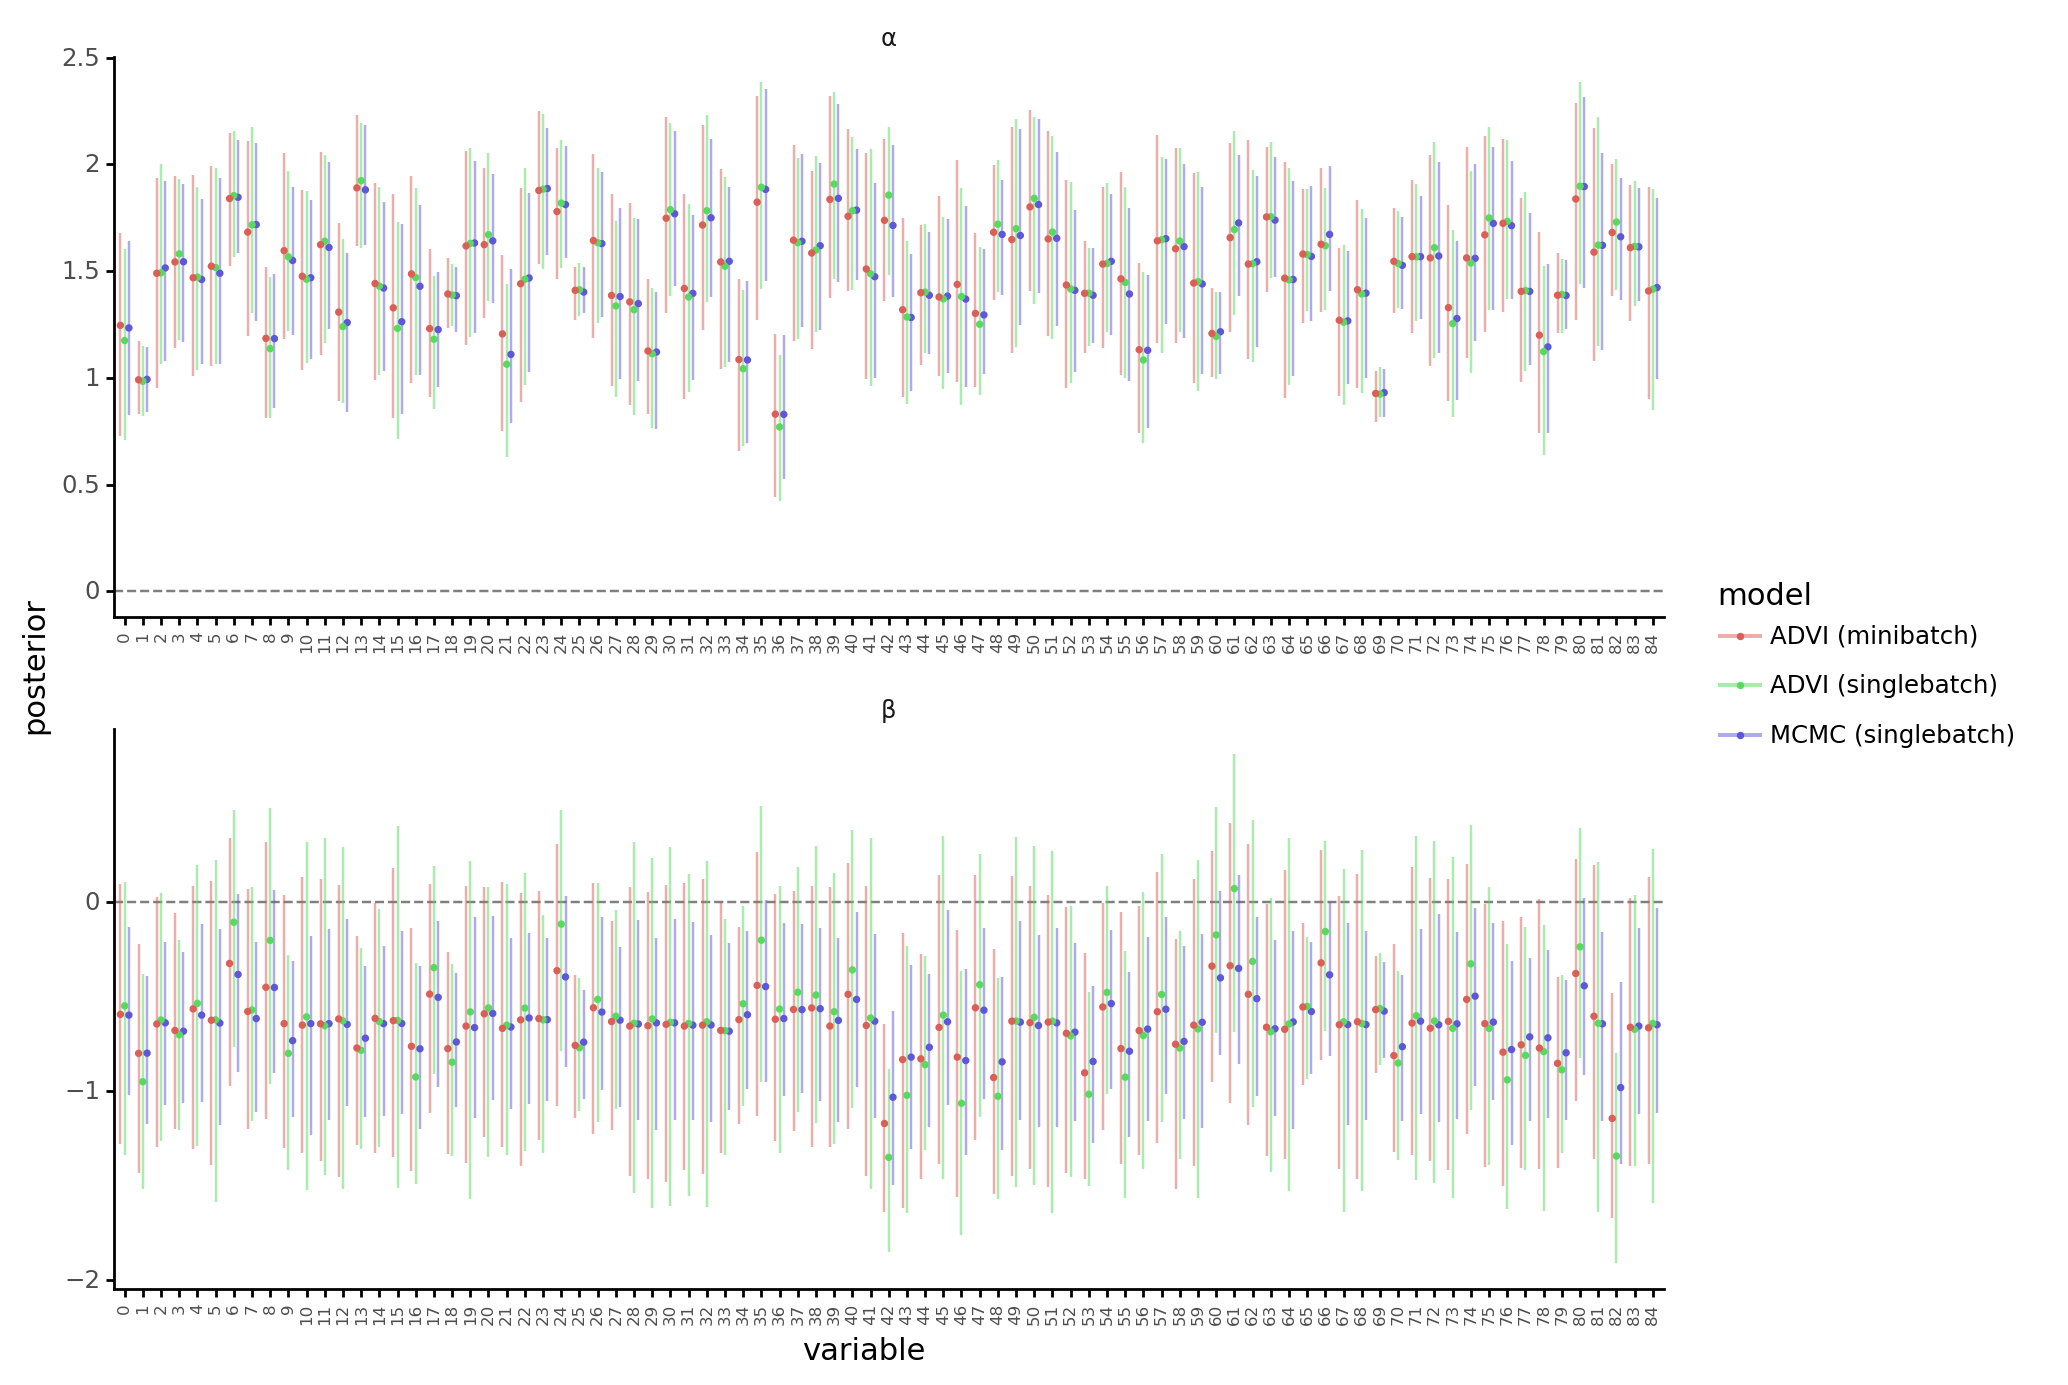

<ggplot: (352490451)>

In [21]:
(
    plot_comparison_of_estimate_summaries(
        mainvars_summaries, x="factor(var_idx)", point_size=0.5
    )
    + gg.facet_wrap("var_group", nrow=2, scales="free")
    + gg.theme(
        figure_size=(10, 8),
        subplots_adjust={"hspace": 0.2},
        axis_text_x=gg.element_text(angle=90, size=6),
    )
)

---

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Feb 17 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

plotnine  : 0.7.1
re        : 2.2.1
matplotlib: 3.3.4
numpy     : 1.20.1
pymc3     : 3.11.1
sys       : 3.9.1 | packaged by conda-forge | (default, Jan 26 2021, 01:32:59) 
[Clang 11.0.1 ]
theano    : 1.1.2
arviz     : 0.11.1
pandas    : 1.2.2

Watermark: 2.1.0

